## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Redes convolucionales

##### Presentado por:

    Arturo Guerrero            (201823464)
    Carlos Andres Paez Rojas   (201924257) 


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas convolucionales (CNN). Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/). 

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas. 

Importemos algunos de los paquetes que vamos a utilizar:


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(1)

Using TensorFlow backend.


In [3]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


## 1. Redes convolucionales

Las redes convolucionales (CNN: *Convolutional Neural Nets*) es un tipo de red neuronal (profunda) que suele usarse para el tratamiento de imagenes y la vision computacional, pero que también sirve para otras tareas como el procesamiento de datos secuenciales, lenguage natural, datos geo-referenciados o datos estructurados que guarden ciertas correlaciones entre sí (ver por ejemplo W. Kim (2014) Convolutional Neural Networks for Sentence Classification). 

Se les concoce por ser invariantes a translaciones, de tal manera que con su arquitectura producen exactamente la misma respuesta ante diferentes traslaciones (como por ejemplo rotaciones) que se le aplique a los datos de entrada. 

Un aspecto importante para entender las CNN de la mano con el tema que hemos visto hasta ahora en el curso, consiste en entender que los pesos y sesgos de una *capa convolucional* son **filtros** que extraen patrones particulares de los datos de entrada. Luego de la extracción de patrones, la red cuenta con capas densamente conectadas donde distintas neuronas pueden compartir el mismo filtro. 

Veamos:
https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093

Entonces, las CNN se pueden entender como versiones regularizadas de las redes multi-capa *densamente conectadas* (donde cada neurona en una capa está conectada con todas las demás neuronas de la siguiente capa). Este tipo de conexión *densa* facilita el *sobre-ajuste* a los datos de muestra con los que se construyen los mdoelos. Así, las CNN se enfocan en construir patrones más complejos pero más simples, encontrando *areas* de atención en las que enfocarse, haciendo uso de filtros y de **convoluciones** (formalmente hablando, una convolución corresponde con la operación matemática de la correlación cruzada). 

Veamos un ejemplo con un filtro de $3\times 3$ y una *stride* de 1:


$$ Imagen = \begin{bmatrix}
    1  & 1  & 1 & 0 & 0\\
    0 & 1 & 1 & 1 & 0 \\
    0  & 0 & 1  & 1 & 1 \\
    0 & 0 & 1 & 1 & 0 \\
    0  & 1 & 1  & 0 & 0
\end{bmatrix};\;\;\; Filtro = \begin{bmatrix}
    1  & 0  & 1\\
    0  & 1 & 0 \\
    1  & 0 & 1 
\end{bmatrix}; \;\;\; Patron =\begin{bmatrix}
    4  & 3  & 4\\
    2  & 4 & 3 \\
    2  & 3 & 4 
\end{bmatrix}$$

Para obtener el nuevo patrón convolucionado, resolvemos la operación $\otimes_1$ denotando una convolución con un *stride* de 1, o una *ventana móvil de 1 en 1*, tal que $Patron = Imagen \otimes_1 Filtro$.



Además de la operación convolucional, tras una capa convolucional le suele seguir un filtro de agregación conocido como **pooling**. Este filtro también toma ventanas móviles y resume los valores dentro de su rango de acuerdo con una operación de agregación específica.

Por ejmplo, un *Max-pooling* consiste en tomar el máximo dentro de cada ventana. Si tomamos un filtro de Max-pooling de tamaño $2\times 2$ y un *stride* de 2, y lo aplicamos sbre el patrón $P$, obtenemos:

$$ P = \begin{bmatrix}
    5  & 4  & 6 & 3\\
    3  & 9 & 4 & 5 \\
    8  & 1 & 7  & 9  \\
    0 & 2 & 8 & 0  
\end{bmatrix}\;\;\; $$

$$ MaxPool_{2\times 2}^{stride=2}(P) = \begin{bmatrix}
    9  & 6\\
    8  & 9
\end{bmatrix}$$


La gran ventaja de las CNN es que aprenden de manera automática (sin necesidad de conocimiento previo) los filtros que de otro modo habría que especificar explícita o manualmente. 

Especifiquemos a continuación la arquitectura de nuestra CNN, donde vamos a hacer uso de una técnica de **Drop-out** antes de la capa de salida. Esta técnica elimina aleatoriamente y de manera temporal (en cada iteración) un número de neuronas determinado (por una tasa de eliminación o *drop-out*), con el fin de que el modelo no recaiga demasidado en ciertas neuronas y generalize de la mejor manera la función a estimar :

In [4]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Optimizador de Adam

Vamos a implementar la red convolucional con la arquitectura especificada arriba haciendo uso del método de optimización estocástica de **Adam** (Kingma & Ba (2015)). El término *Adam* se debe a *Adaptive Moment Estimation*, y se puede entender como una revisión al método de RMSProp. Bajo Adam, se utilizan promedios móviles tanto de los gradientes como de sus segundos momentos.  De esta manera, se tiene que 

$$ u(\theta) = \rho_1 u(\theta_{viejo}) + (1-\rho_1) \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }  $$

$$ v(\theta) = \rho_2 v(\theta_{viejo}) + (1-\rho_2) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$

donde

$$ \hat u = \frac{u(\theta)}{1-\rho_1^t} $$

$$ \hat v = \frac{v(\theta)}{1-\rho_2^t} $$

De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\hat u}{\sqrt{\hat v}+\varepsilon}$$ 

donde $\varepsilon$ es un escalar muy pequeño (infinitesimal) que previene la división por cero, $\rho_1, \rho_2$ son respectivamente  los factores de memoria sobre el primer y segundo momento de los gradientes. 

In [17]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

histories = {}

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
        histories["seed_"+str(r)] = history

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    
print(x)

Epoca= 25 , accu_v1=0.8918918967247009 , accu_v2=0.8684210777282715
Epoca= 21 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697
Epoca= 84 , accu_v1=0.9189189076423645 , accu_v2=0.9736841917037964
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8919 | 0.8684 |   25  |
|  0.6   | 0.4595 | 0.6053 |   21  |
|  1.0   | 0.9189 | 0.9737 |   84  |
+--------+--------+--------+-------+


### Pregunta 3.1

Qué puede observar sobre estos resultados?

_El modelo presenta en el set de entrenamiento una alta exactitud, y en los sets de validación, no se presenta un sobre ajuste. En la epoca 19 ya el modelo alcanza buenas cifras de exactitud. A priori, se puede deicr, que tiene un mejor desempeño con respecto a las redes entrenadas anteriormente, pues se está logrando un Accuracy Score superior a 0.9 en datos de validación en la última iteración_

Visualicemos el aprendizaje del mejor modelo:

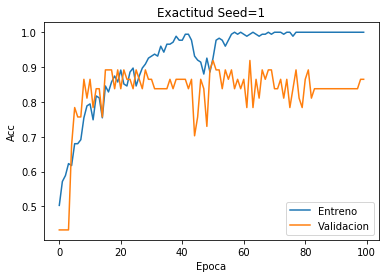

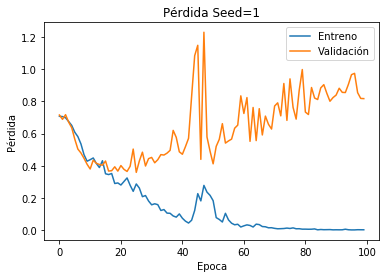

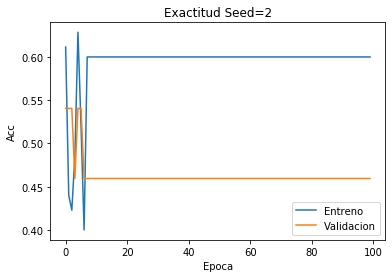

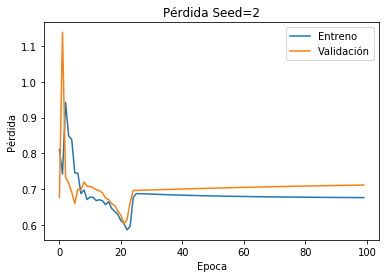

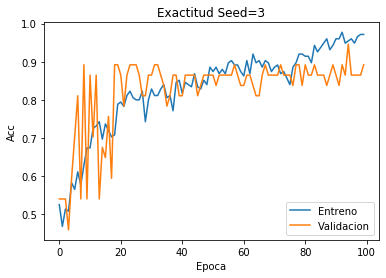

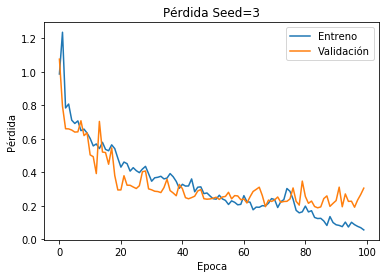

In [33]:
i = 0
for key in histories.keys():
    history = histories[key]
    i=i+1
    plt.figure(i)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud Seed='+str(i))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(i) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida Seed='+str(i))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [13]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

Veamos el desempeño del mejor modelo sobre todo el conjunto de datos:

In [14]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[140,   5],
       [  6,  99]])

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 134 </td>
       <td> 11 </td>
    </tr>
    <tr>
       <td> 4 </td>
       <td> 101 </td>
    </tr>

</table>

### Ejercicio 1.1

Intente hacer que el optimizador Adam converja en todas las repeticiones. 


In [267]:
def cnn(config_cnn, opt):
    # Inicializamos la tabla donde guardamos los resultados
    x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

    # Definimos el número máximo de iteraciones (épocas de la red)
    epocas=100

    # Inicializamos el error 
    err_p = 999

    for i in range(0,3,1):
        r = i^3
        CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
        CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)

         # Definimos la arquitectura de la red
        model = Sequential.from_config(config_cnn)

        # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Ajustamos el modelo
        history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Encontramos el mejor modelo en validación
        min_err=np.min(history.history['val_loss'])
        best_epoc=np.where(history.history['val_loss'] == min_err)[0] 

        # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
        model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Calculamos las metricas
        train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
        valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
        test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)

        ## Guardamos las métricas de desempeño
        accu_e = train_metrics[1]
        loss_e = train_metrics[0]
        accu_v = valid_metrics[1]
        loss_v = valid_metrics[0]
        accu_p = test_metrics[1]
        loss_p = test_metrics[0]

        if (loss_p < err_p):
            pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
            model.save(pathr) 
            err_p = loss_p

        # Imprimimos el desempeño para cada repetición
        print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))

        x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

        plt.figure(1)
        plt.plot(history.history['accuracy'])  
        plt.plot(history.history['val_accuracy'])  
        plt.title('Exactitud')  
        plt.ylabel('Acc')  
        plt.xlabel('Epoca')  
        plt.legend(['Entreno', 'Validacion'], loc='lower right')
        plt.show()

        plt.figure(1) 
        plt.plot(history.history['loss'])  
        plt.plot(history.history['val_loss'])  
        plt.title('Pérdida')  
        plt.ylabel('Pérdida')  
        plt.xlabel('Epoca')  
        plt.legend(['Entreno', 'Validación'], loc='upper right')  
        plt.show()
    return x

_Con previas validaciones realizadas, identificamos que al disminuir los parámetros betas empeora el desempeño de la red, lo aconsejable es usar valores cercanos a 1. Por otro lado, al disminuir la tasa de aprendizaje se puede intuir una leve mejora en el desempeño y mejor generalización_. 

Adam - learning rate: 0.0005
Epoca= 21 , accu_v1=0.837837815284729 , accu_v2=0.8684210777282715


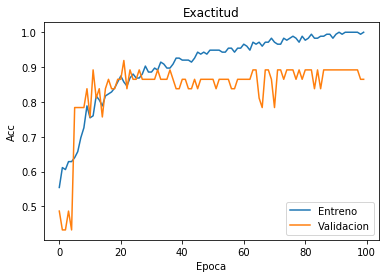

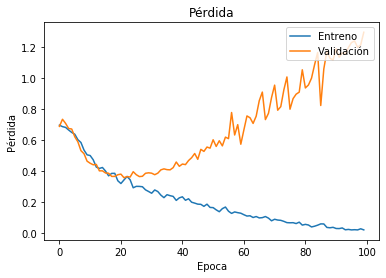

Epoca= 31 , accu_v1=0.8918918967247009 , accu_v2=0.8684210777282715


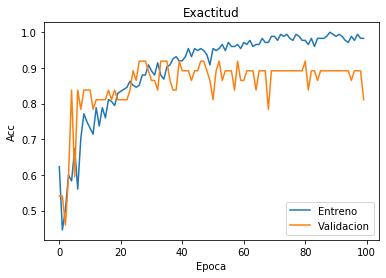

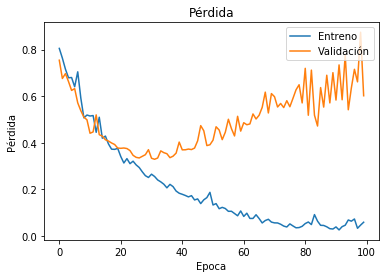

Epoca= 18 , accu_v1=0.8648648858070374 , accu_v2=0.9210526347160339


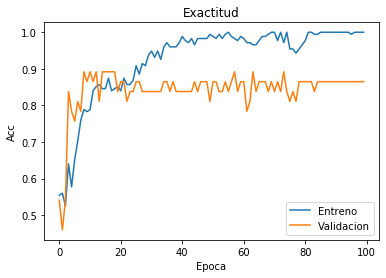

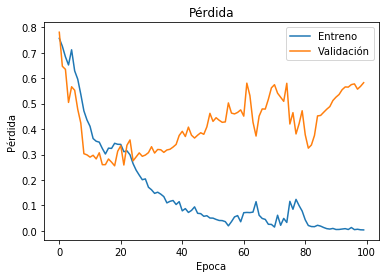

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8684 |   21  |
|  1.0   | 0.8919 | 0.8684 |   31  |
|  1.0   | 0.8649 | 0.9211 |   18  |
+--------+--------+--------+-------+
Adam - learning rate: 0.0002
Epoca= 39 , accu_v1=0.837837815284729 , accu_v2=0.8684210777282715


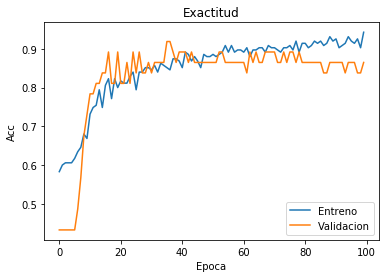

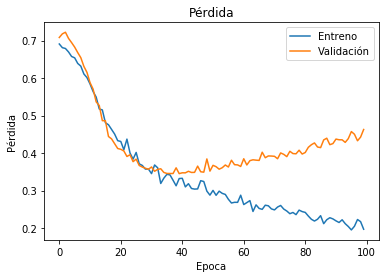

Epoca= 64 , accu_v1=0.8918918967247009 , accu_v2=0.8421052694320679


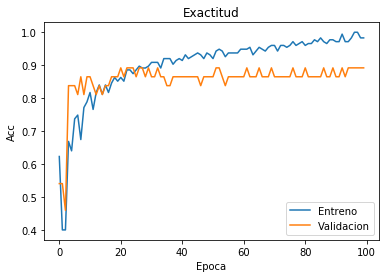

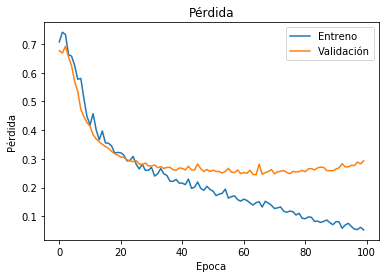

Epoca= 36 , accu_v1=0.8648648858070374 , accu_v2=0.9473684430122375


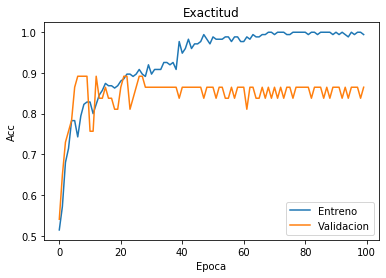

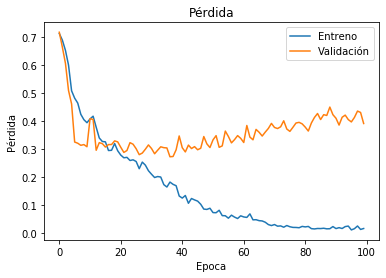

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9486 | 0.8378 | 0.8684 |   39  |
|  1.0   | 0.8919 | 0.8421 |   64  |
|  1.0   | 0.8649 | 0.9474 |   36  |
+--------+--------+--------+-------+
Adam - learning rate: 0.000125
Epoca= 46 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715


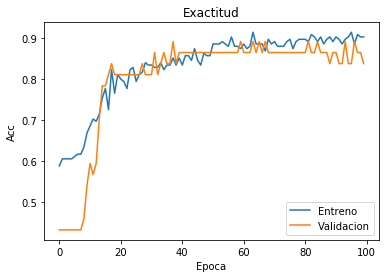

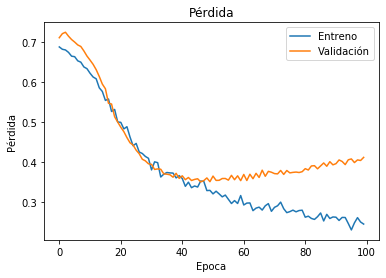

Epoca= 88 , accu_v1=0.8648648858070374 , accu_v2=0.8157894611358643


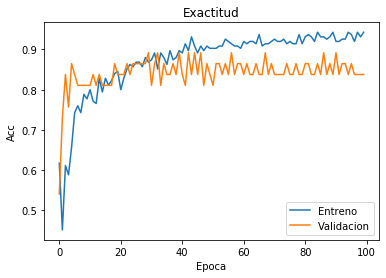

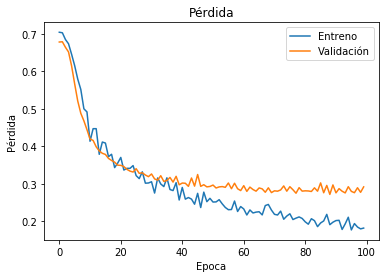

Epoca= 36 , accu_v1=0.8108108043670654 , accu_v2=0.8684210777282715


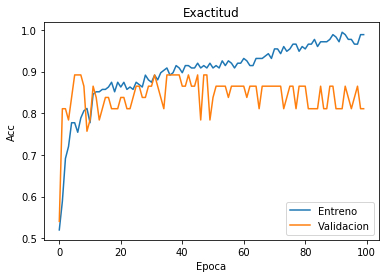

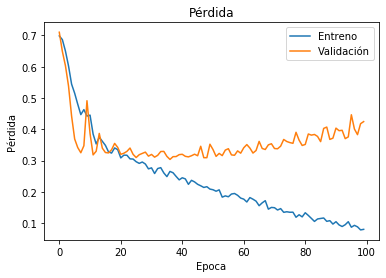

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9371 | 0.8649 | 0.8684 |   46  |
| 0.9771 | 0.8649 | 0.8158 |   88  |
|  1.0   | 0.8108 | 0.8684 |   36  |
+--------+--------+--------+-------+


In [268]:
### implementamos 3 repeticiones con tasas de aprendizaje distintas para el optimizador Adam
for j in range(2,10,3):
    # Definimos los parametros del Adam
    opt = keras.optimizers.Adam(lr=0.001 / j, beta_1=0.9, beta_2=0.999)
    print('Adam - learning rate: ' + str(0.001 / j))
    x = cnn(config_cnn, opt)
    print(x)

_Con una tasa de aprendizaje de **0.0002** se obtiene un Accuracy Score superior a **0.86** para todas las repeticiones con el set de datos de prueba. Y obteniendo **0.92** en la última_.

### Ejercicio 1.2

Compare los resultados al utilizar otros algoritmos de aprendizaje como RMSprop o el mismo SGD


Epoca= 46 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715


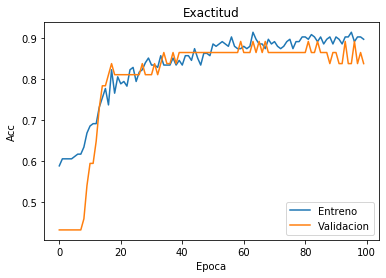

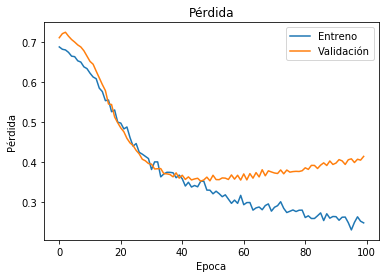

Epoca= 88 , accu_v1=0.837837815284729 , accu_v2=0.8157894611358643


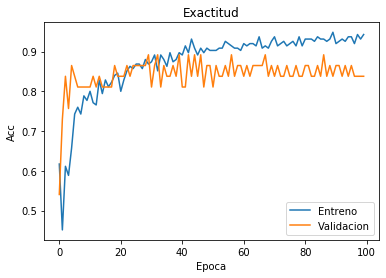

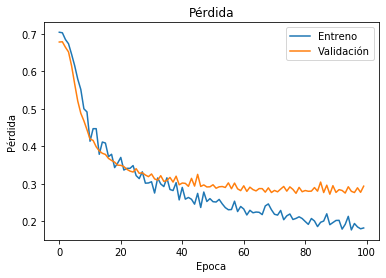

Epoca= 36 , accu_v1=0.8108108043670654 , accu_v2=0.8684210777282715


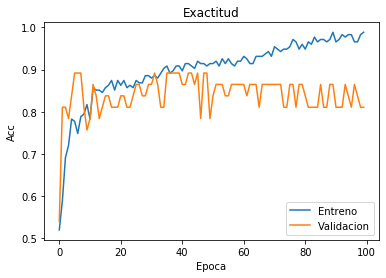

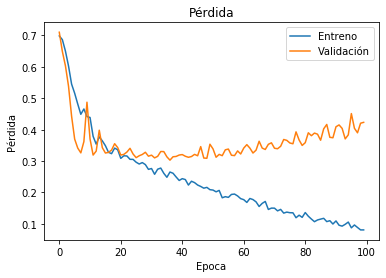

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9371 | 0.8649 | 0.8684 |   46  |
| 0.9829 | 0.8378 | 0.8158 |   88  |
|  1.0   | 0.8108 | 0.8684 |   36  |
+--------+--------+--------+-------+
Epoca= 99 , accu_v1=0.8108108043670654 , accu_v2=0.8684210777282715


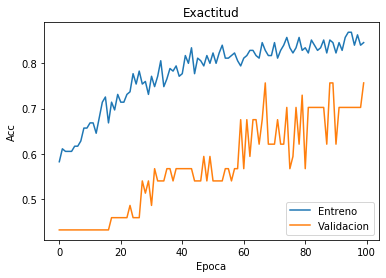

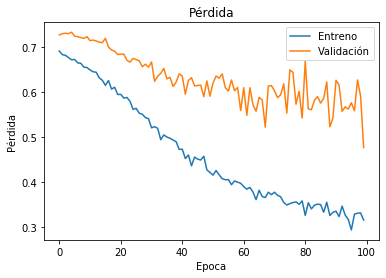

Epoca= 99 , accu_v1=0.8648648858070374 , accu_v2=0.8157894611358643


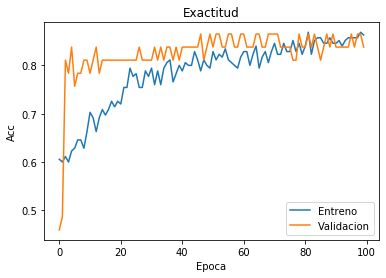

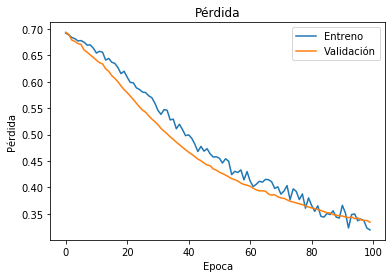

Epoca= 95 , accu_v1=0.8648648858070374 , accu_v2=0.8947368264198303


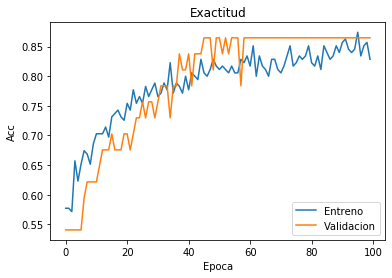

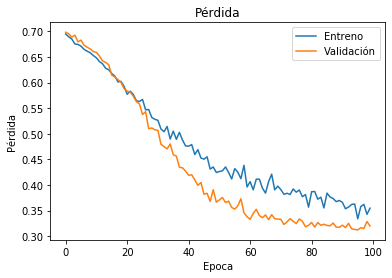

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9257 | 0.8108 | 0.8684 |   99  |
| 0.9371 | 0.8649 | 0.8158 |   99  |
| 0.9029 | 0.8649 | 0.8947 |   95  |
+--------+--------+--------+-------+
Epoca= 31 , accu_v1=0.4324324429035187 , accu_v2=0.6052631735801697


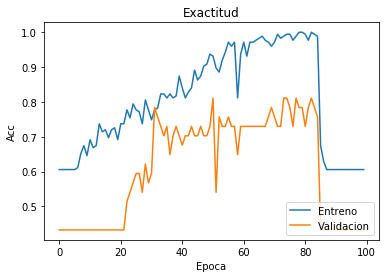

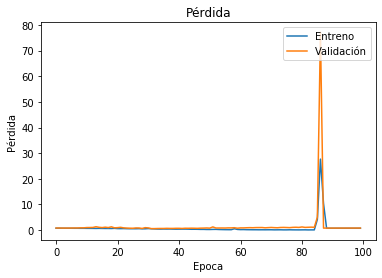

Epoca= 50 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697


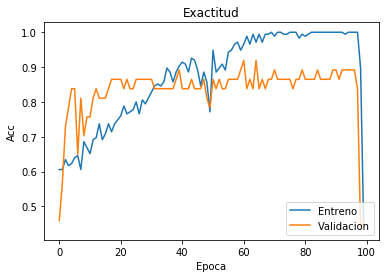

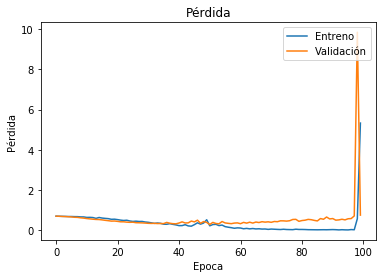

Epoca= 35 , accu_v1=0.837837815284729 , accu_v2=0.8947368264198303


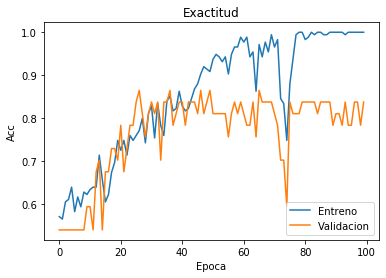

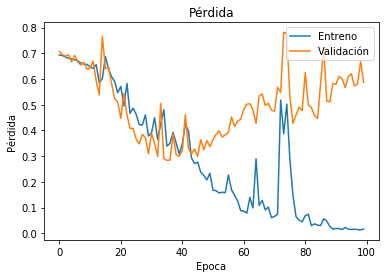

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.6057 | 0.4324 | 0.6053 |   31  |
|  0.6   | 0.4595 | 0.6053 |   50  |
|  1.0   | 0.8378 | 0.8947 |   35  |
+--------+--------+--------+-------+


In [40]:
# Definimos los parametros de los optimizadores
adam = keras.optimizers.Adam(lr=0.000125, beta_1=0.9, beta_2=0.999)
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)
sgd = SGD(lr=0.05, momentum=0.09)

# implementamos 3 repeticiones, para cada optimizador
for j in range(0,3,1):
    if j == 0:
        opt = adam
        print(str(opt))
        x = cnn(config_cnn, opt)
        print(x)
    else:
        if j == 1:
            opt = rmsprop
            print(str(opt))
            x = cnn(config_cnn, opt)
            print(x)
        else:
            opt = sgd
            print(str(opt))
            x = cnn(config_cnn, opt)
            print(x)

_Se observa mejor desempeño con el optimizador “Adam”, comparado con RMSProp y SGD. Aunque se observaría mejor generalización con SGD observando en conjunto todas las repeticiones_.

### Ejercicio 1.3

Compare los resultados con distintas tasas de *drop-out*.  

In [41]:
def ini_cnn(rate):
    #inicializacion Normal
    initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

    # Inicializacion de He
    initHe = keras.initializers.he_normal(seed=1)

    # Arquitectura de la red
    model = Sequential()  
    model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
    model.add(Dropout(rate=0.2, seed=1))   
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

    # Guardamos la arquitectura de red
    config_cnn = model.get_config()
    return(config_cnn)

_Se toma la parametrización de la mejor red obtenida anteriormente y se evalúan tasas de DropOut de **0.1**, **0.3** y **0.5**_.

Dropout rate: 0.1
Epoca= 46 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715


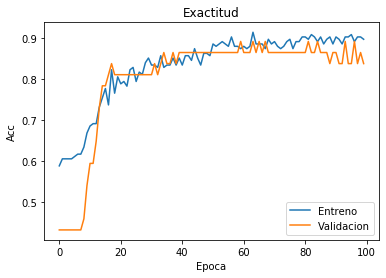

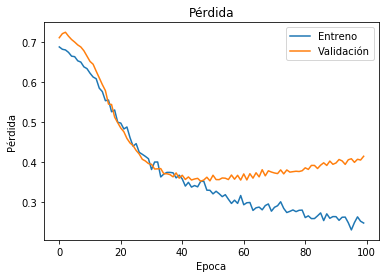

Epoca= 88 , accu_v1=0.837837815284729 , accu_v2=0.8157894611358643


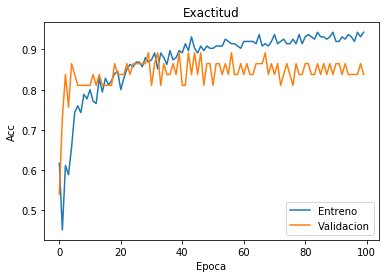

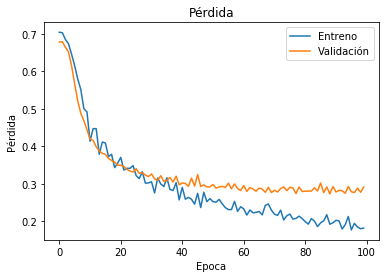

Epoca= 36 , accu_v1=0.8108108043670654 , accu_v2=0.8684210777282715


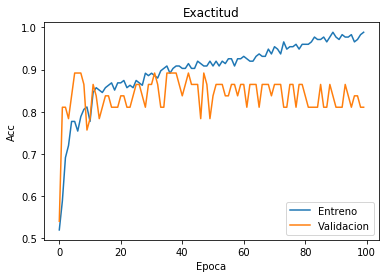

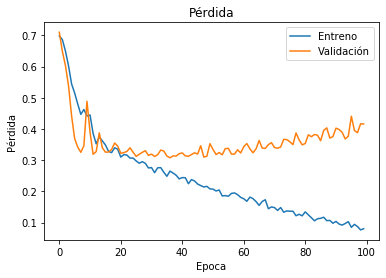

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9371 | 0.8649 | 0.8684 |   46  |
| 0.9886 | 0.8378 | 0.8158 |   88  |
|  1.0   | 0.8108 | 0.8684 |   36  |
+--------+--------+--------+-------+
Dropout rate: 0.30000000000000004
Epoca= 22 , accu_v1=0.8648648858070374 , accu_v2=0.8947368264198303


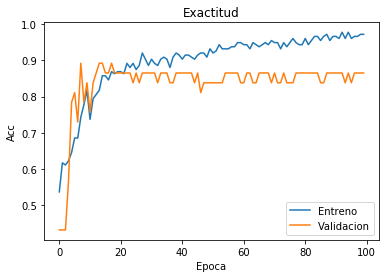

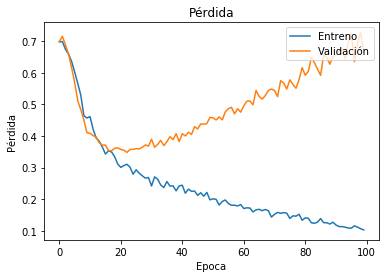

Epoca= 98 , accu_v1=0.8648648858070374 , accu_v2=0.8421052694320679


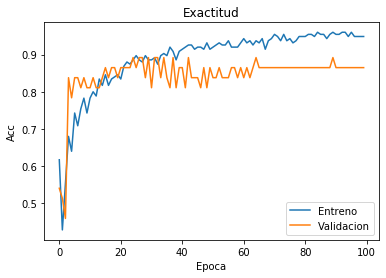

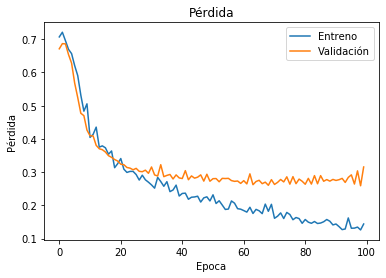

Epoca= 36 , accu_v1=0.8108108043670654 , accu_v2=0.9210526347160339


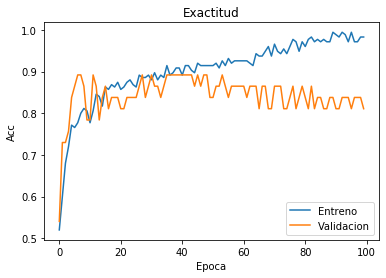

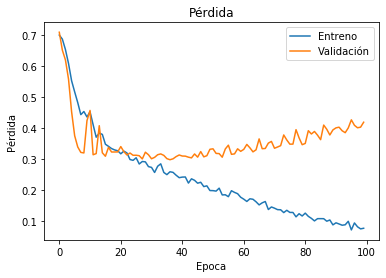

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9771 | 0.8649 | 0.8947 |   22  |
|  1.0   | 0.8649 | 0.8421 |   98  |
|  1.0   | 0.8108 | 0.9211 |   36  |
+--------+--------+--------+-------+
Dropout rate: 0.5
Epoca= 22 , accu_v1=0.837837815284729 , accu_v2=0.8947368264198303


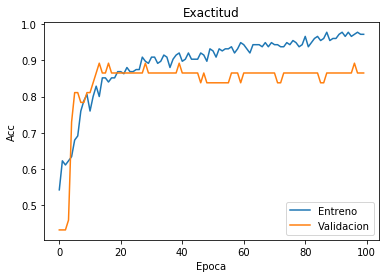

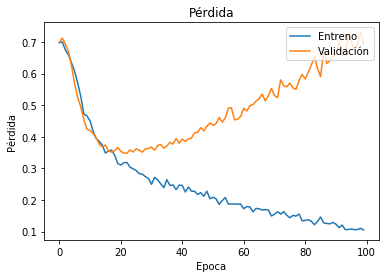

Epoca= 63 , accu_v1=0.8918918967247009 , accu_v2=0.8684210777282715


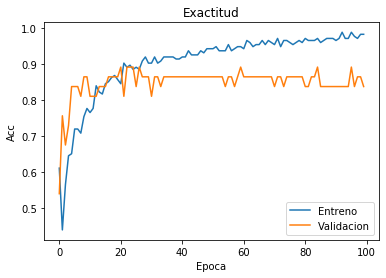

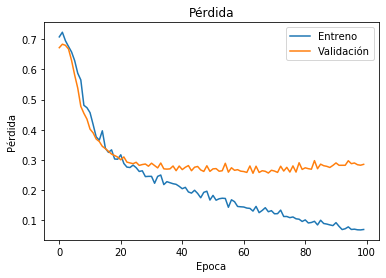

Epoca= 36 , accu_v1=0.8108108043670654 , accu_v2=0.8947368264198303


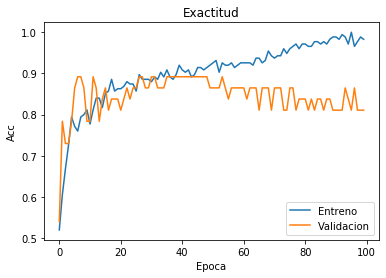

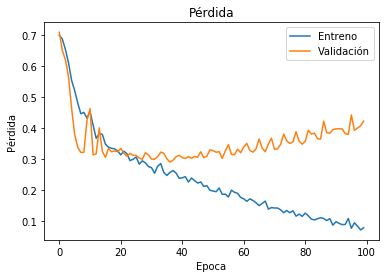

+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9771 | 0.8378 | 0.8947 |   22  |
|  1.0   | 0.8919 | 0.8684 |   63  |
|  1.0   | 0.8108 | 0.8947 |   36  |
+--------+--------+--------+-------+


In [42]:
adam = keras.optimizers.Adam(lr=0.000125, beta_1=0.9, beta_2=0.999)
rate=0.1
for j in range(0,3,1):
    config_cnn = ini_cnn(rate)
    print('Dropout rate: ' + str(rate))
    opt = adam
    print(str(opt))
    x = cnn(config_cnn, opt)
    print(x)
    rate = rate + 0.2

_Por consiguiente, se observa una leve mejora en el desempeño entrenando la red con tasa de DropOut de **0.3**_.

### Bono

Visualice los distintos filtros convolucionales para entender qué tipo de patrones están aprendiendo que son relevantes para la detección de frailejones.

*A continuación se indica cómo visulizar una capa convolucional. Examine las distintas capas convolucionales y analice lo que puede visualizar.*

In [43]:
from matplotlib import pyplot

In [88]:
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)             

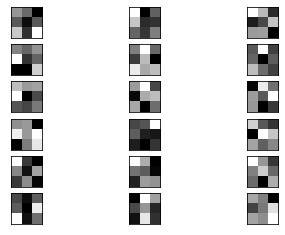

In [90]:

# cargamos los pesos de la primera capa escondida
filters, biases = model_3.layers[0].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 6, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
    # graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura

pyplot.show()

Realizamos una pequeña busqueda para solamente encontrar las capas convolucionales

In [102]:
# load the model
model = model_3
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

0 conv2d_10 (?, 68, 68, 32)
2 conv2d_11 (?, 32, 32, 32)
4 conv2d_12 (?, 14, 14, 64)


Sobre nuestro modelo, tenemos que los indices [0,2,4] pertenecen a capas convolucionales. Exploremos un poco la primera capa, creando un modelo nuevo que solamente involucre la primera capa.

In [182]:
from keras.models import Model
model = Model(inputs=model_3.inputs, outputs=model_3.layers[0].output)
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 68, 68, 32)        896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


Cargamos la imagen.

In [183]:
img = image.load_img('IMG_3451.JPG')

Obtenemos el set de imágenes con frailejones

In [184]:
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
img_subset = []
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        img_subset.append(subi2)
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50

En total tenemos 4661 elementos

Convertimos la imagen a un array de forma  [samples, rows, cols, channels]

Se obtienen las características aplicando la primera capa, el primer patrón.

In [234]:
feature_maps = model.predict(img_subset[0])

Gráficamos las 32 imagénes que se encuentran en las carácteristicas extraídas.

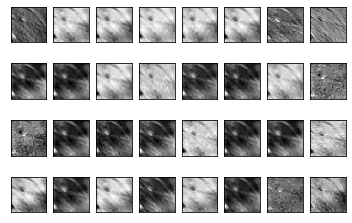

In [195]:
ix = 1
for _ in range(4):
    for _ in range(8):
        # specify subplot and turn of axis
        ax = pyplot.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

Al ser la primera capa, las carácetiristicas extraídas de la primera muestra se observa a priori formas parecidas a escamas. Veamos que sucede si aplicamos el mismo filtro convolucional de la primera capa sobre otras imágenes.

In [236]:
from keras.models import Model
model = Model(inputs=model_3.inputs, outputs=model_3.layers[0].output)
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 68, 68, 32)        896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


Caracteristicas de la imagen: 0, Primera capa convolucional


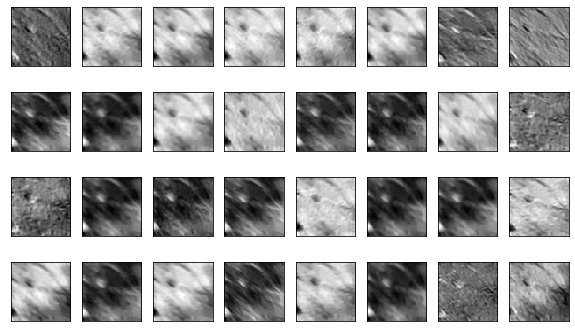

Caracteristicas de la imagen: 1061, Primera capa convolucional


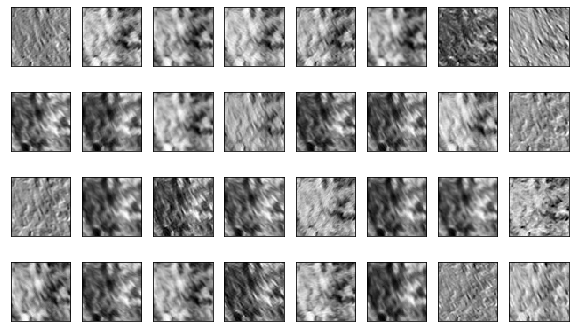

Caracteristicas de la imagen: 3409, Primera capa convolucional


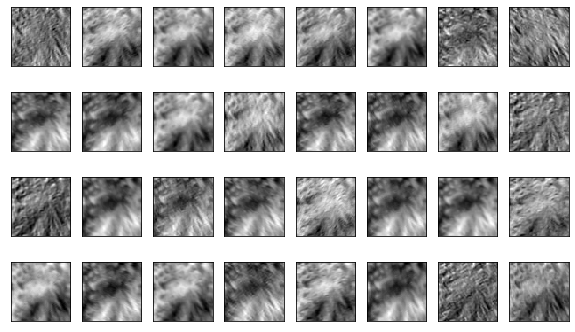

Caracteristicas de la imagen: 439, Primera capa convolucional


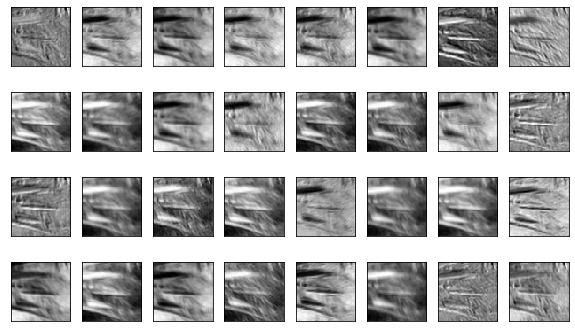

Caracteristicas de la imagen: 3938, Primera capa convolucional


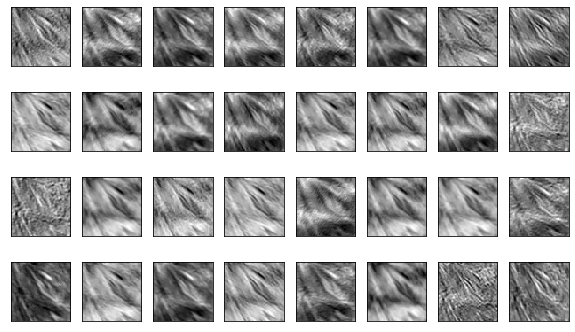

In [237]:
#1061, 3409, 439, 3938
import random
for id_img in [0, 1061, 3409, 439, 3938]:
    pyplot.figure(figsize=(10,6))
    print(f"Caracteristicas de la imagen: {id_img}, Primera capa convolucional")
    feature_maps = model.predict(img_subset[id_img])
    ix = 1
    for _ in range(4):
        for _ in range(8):
            # specify subplot and turn of axis
            ax = pyplot.subplot(4, 8, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

Veamos ahora que sucede para estas mismas imágenes, sobre las otras capas. A continuación en la segunda capa de convulción.

In [238]:
from keras.models import Model
model = Model(inputs=model_3.inputs, outputs=model_3.layers[2].output)
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


Caracteristicas extraídas de la imagen: 0, Segunda capa convolucional


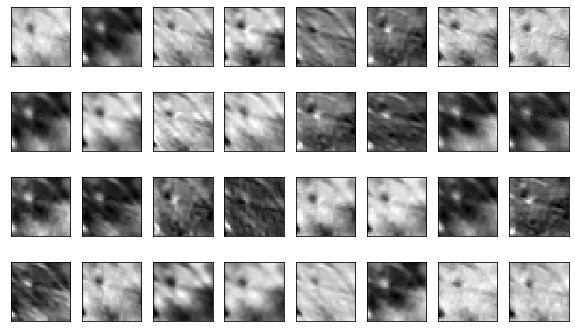

Caracteristicas extraídas de la imagen: 1061, Segunda capa convolucional


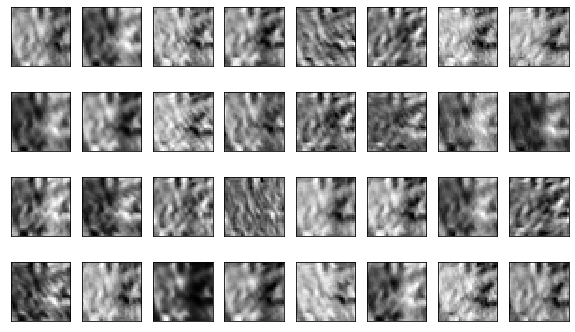

Caracteristicas extraídas de la imagen: 3409, Segunda capa convolucional


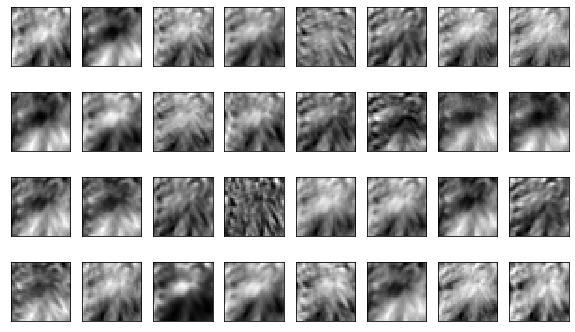

Caracteristicas extraídas de la imagen: 439, Segunda capa convolucional


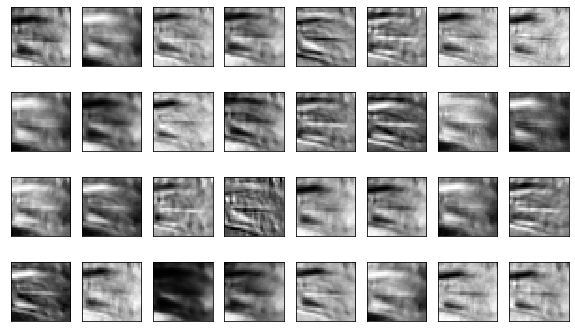

Caracteristicas extraídas de la imagen: 3938, Segunda capa convolucional


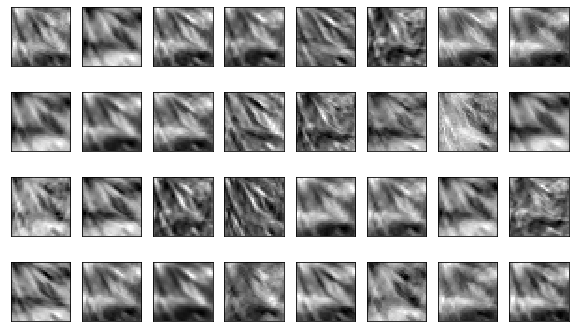

In [239]:
for id_img in [0, 1061, 3409, 439, 3938]:
    pyplot.figure(figsize=(10,6))
    print(f"Caracteristicas extraídas de la imagen: {id_img}, Segunda capa convolucional")
    feature_maps = model.predict(img_subset[id_img])
    ix = 1
    for _ in range(4):
        for _ in range(8):
            ax = pyplot.subplot(4, 8, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

Ahora veamos la última capa convolucional (index = 4).

In [240]:
from keras.models import Model
model = Model(inputs=model_3.inputs, outputs=model_3.layers[4].output)
model.summary()
feature_maps = model.predict(img_subset[0])
feature_maps.shape

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
______________________________________________________

(1, 14, 14, 64)

Caracteristicas extraídas de la imagen: 0, Tercera capa convolucional


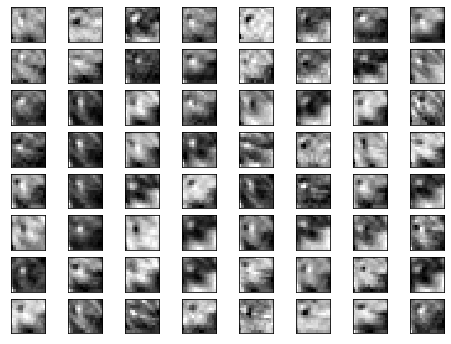

Caracteristicas extraídas de la imagen: 1061, Tercera capa convolucional


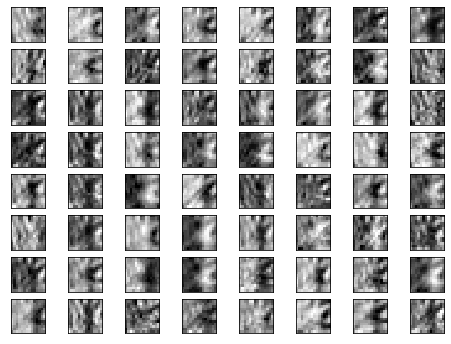

Caracteristicas extraídas de la imagen: 3409, Tercera capa convolucional


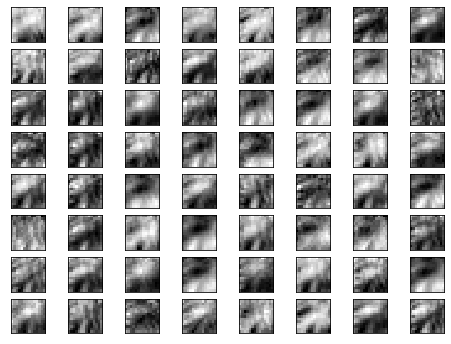

Caracteristicas extraídas de la imagen: 439, Tercera capa convolucional


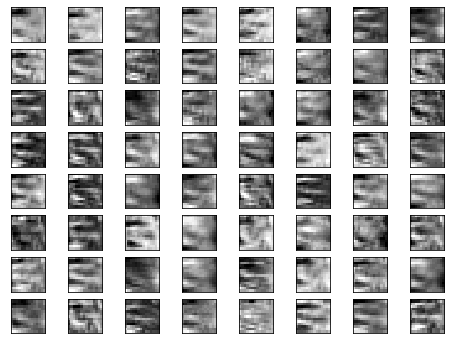

Caracteristicas extraídas de la imagen: 3938, Tercera capa convolucional


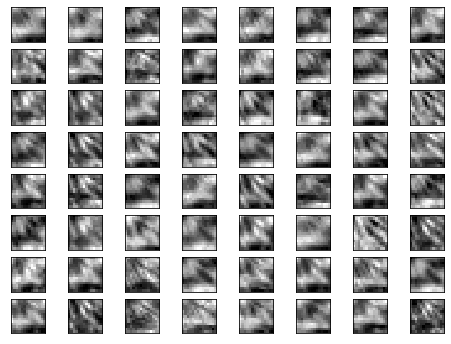

In [244]:

for id_img in [0, 1061, 3409, 439, 3938]:
    pyplot.figure(figsize=(8,6))
    print(f"Caracteristicas extraídas de la imagen: {id_img}, Tercera capa convolucional")
    feature_maps = model.predict(img_subset[id_img])
    ix = 1
    for _ in range(8):
        for _ in range(8):
            # specify subplot and turn of axis
            ax = pyplot.subplot(8, 8, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

La última capa presenta imágenes mas pequeñas, sin embargo, se espera que sea donde se presenta la mayor caracterización de la imagenes de entrada.

## 2. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


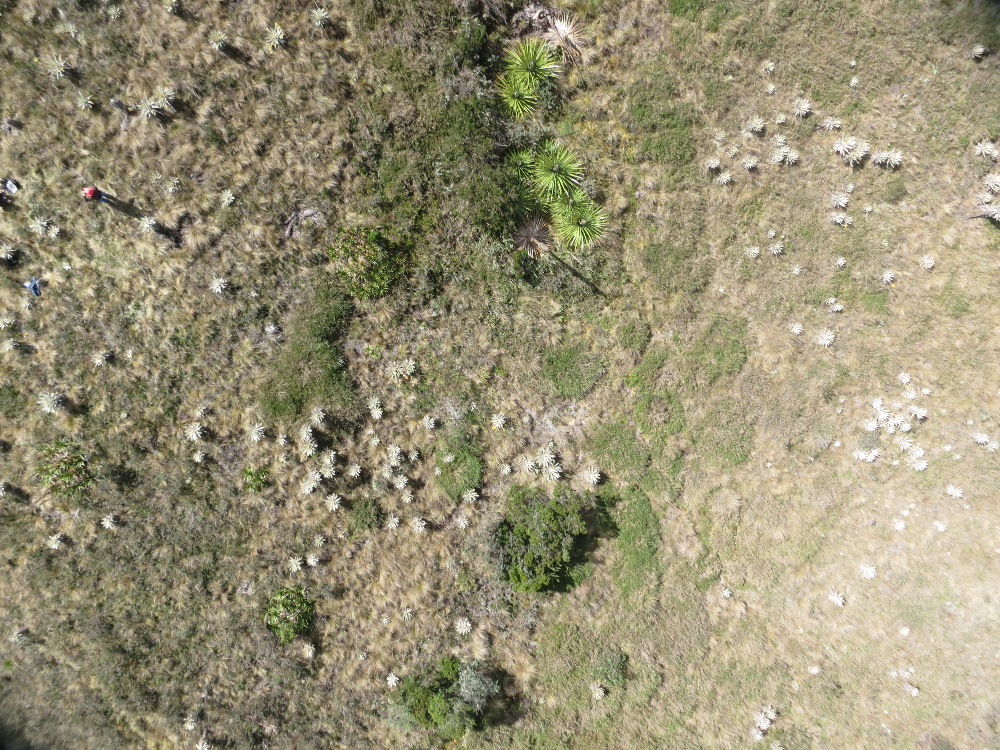

In [260]:
from keras.preprocessing.image import image

img = image.load_img('IMG_3451.JPG')
img2 = image.load_img('IMG_3451.JPG', target_size=(750, 1000))
img2

### Red Convolucional

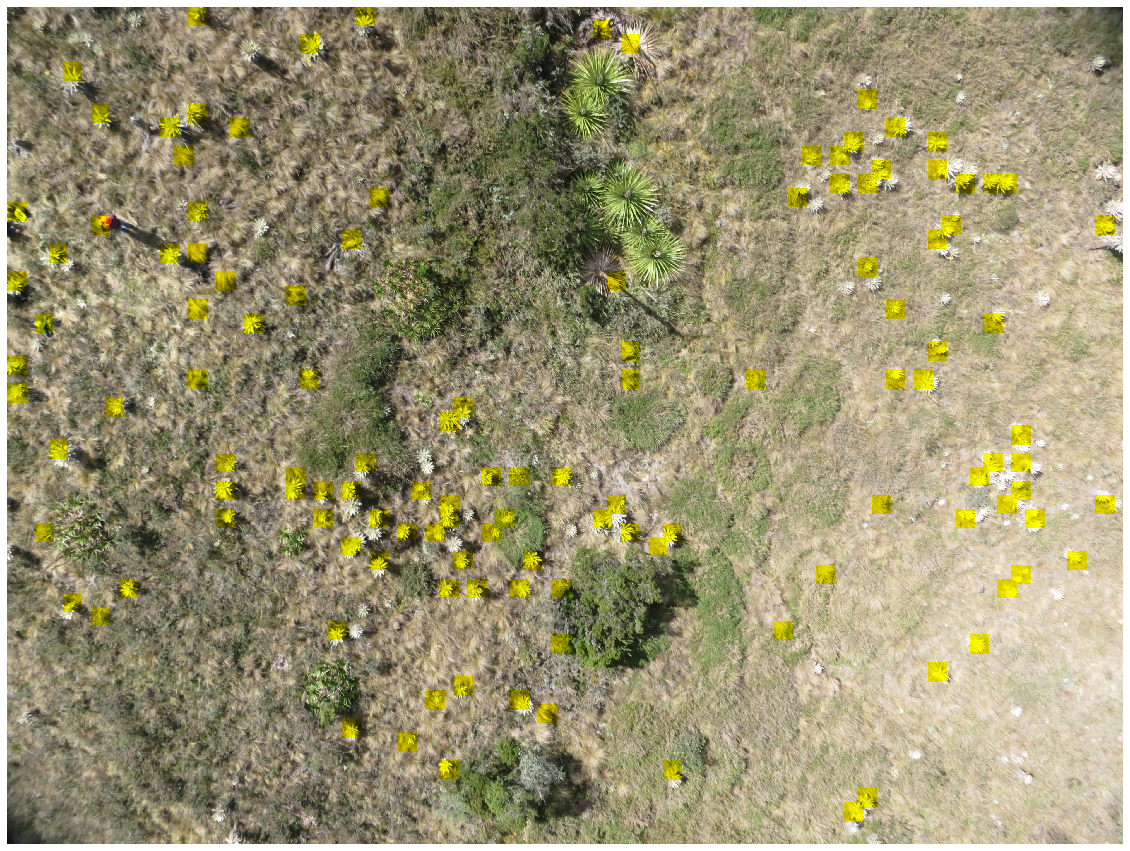

In [266]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_3.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(x2)


Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf
        

_Visualmente, se observa una reducción de falsos positivos al costado inferior derecho de la imagen. Se intuye mayor exactitud en la identificación de frailejones, aunque aún se observan áreas importantes sin dicha identificación._